In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=2c0ab3d1f516a30144461c873b70cb114d8bb11eefbf69e1700f7a4677d87761
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime.lime_tabular
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.inspection import PartialDependenceDisplay
from lime.lime_tabular import LimeTabularExplainer
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats.stattools import durbin_watson
from sklearn.preprocessing import StandardScaler

In [ ]:
X_train = pd.read_csv('/content/X_train_final.csv')
X_test = pd.read_csv('/content/X_test_final.csv')
y_train = pd.read_csv('/content/y_train_final.csv').squeeze()
y_test = pd.read_csv('/content/y_test_final.csv').squeeze()

In [ ]:
# Cleaning Column Names
for df in [X_train, X_test]:
    df.columns = df.columns.str.replace(r"[\[\]\(\),<]", "_", regex=True)
    df.columns = df.columns.str.replace(r"\s+", "_", regex=True)

In [ ]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n{name} Evaluation")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(f"AUC: {roc_auc_score(y_test, y_pred):.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

#Logistic Regression


Logistic Regression Evaluation
Accuracy: 0.93
Precision: 0.93
Recall: 0.94
F1 Score: 0.93
AUC: 0.93
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       544
           1       0.93      0.94      0.93       635

    accuracy                           0.93      1179
   macro avg       0.93      0.93      0.93      1179
weighted avg       0.93      0.93      0.93      1179



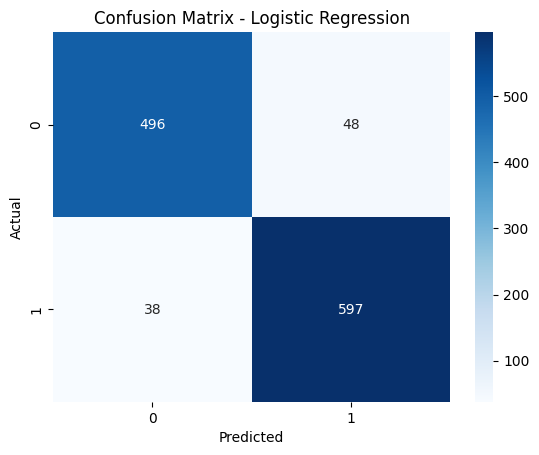

In [ ]:
log_model = LogisticRegression(max_iter=1000, solver='liblinear')
log_model.fit(X_train, y_train)
evaluate_model("Logistic Regression", log_model, X_test, y_test)

In [ ]:
# Binary Outcome Check
print("Target classes:", y_train.unique())
print("Class distribution:\n", y_train.value_counts())

Target classes: [1 0]
Class distribution:
 0
1    2536
0    2176
Name: count, dtype: int64


In [ ]:
# Durbin-Watson Test (Independence of Residuals)
X_train_numeric = X_train.select_dtypes(include=np.number)
y_train_numeric = y_train.loc[X_train_numeric.index]
X_const = add_constant(X_train_numeric)

logit_model = sm.Logit(y_train_numeric, X_const).fit(disp=0)
dw_stat = durbin_watson(logit_model.resid_response)
print(f"Durbin-Watson statistic: {dw_stat:.3f}")

Durbin-Watson statistic: 2.066


Since value is very close to 2, this confirms that the residuals from logistic regression model are independent — satisfying the no autocorrelation assumption.

In [ ]:
# VIF (Multicollinearity Check)
vif_df = pd.DataFrame()
vif_df["Feature"] = X_const.columns
vif_df["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
print("Variance Inflation Factors:")
print(vif_df)

Variance Inflation Factors:
                Feature          VIF
0                 const  2069.154884
1        MonthlyCharges   397.487364
2  MonthlyCostPerTenure     1.661588
3          TotalCharges     8.121655
4        discount_score   397.620825
5     is_family_package     1.182002
6                tenure     7.640490


VIF measures how much the variance of a regression coefficient is inflated due to multicollinearity.

VIF < 5: Low multicollinearity

VIF between 5 and 10: Moderate multicollinearity

VIF > 10: Severe multicollinearity

In [ ]:
# Box-Tidwell Test
continuous_features = ['MonthlyCostPerTenure', 'TotalCharges', 'MonthlyCharges', 'tenure', 'discount_score']
X_bt = X_train[continuous_features].apply(pd.to_numeric, errors='coerce').dropna()
y_bt = y_train.loc[X_bt.index]
for feature in continuous_features:
    X_bt[f'{feature}_log'] = X_bt[feature] * np.log(np.abs(X_bt[feature]) + 1e-6)
X_bt_const = add_constant(X_bt)
box_tidwell_model = sm.Logit(y_bt, X_bt_const).fit()
print("\nBox-Tidwell Test - Linearity of the Logit")
print(box_tidwell_model.pvalues[[f'{f}_log' for f in continuous_features]])

Optimization terminated successfully.
         Current function value: 0.225876
         Iterations 9

Box-Tidwell Test - Linearity of the Logit
MonthlyCostPerTenure_log    0.000010
TotalCharges_log            0.801447
MonthlyCharges_log          0.347652
tenure_log                  0.014442
discount_score_log          0.004056
dtype: float64


This test assesses whether each continuous predictor has a linear relationship with the logit of the dependent variable.

If the p-value is < 0.05, the relationship is non-linear

If the p-value is ≥ 0.05, the relationship is linear

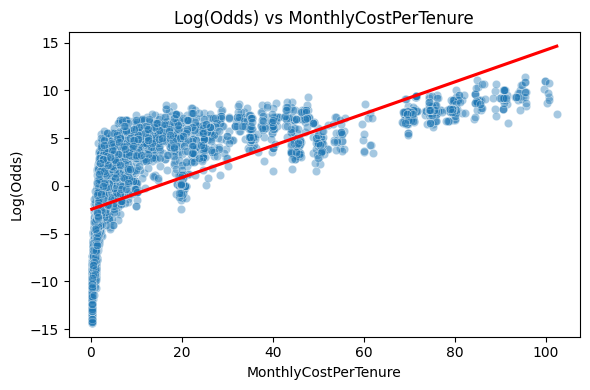

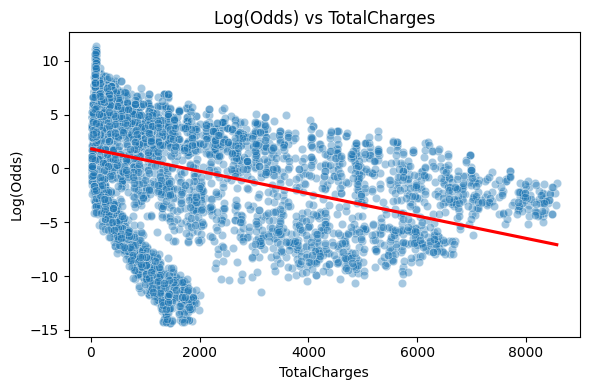

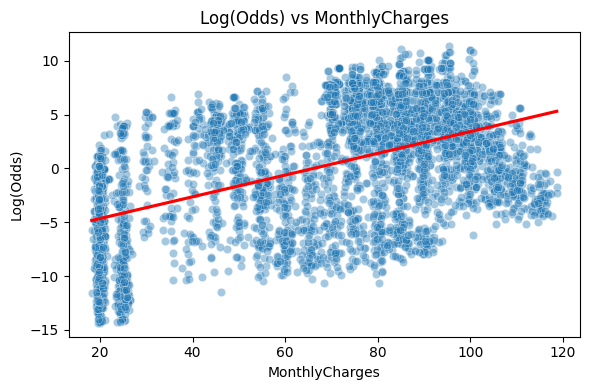

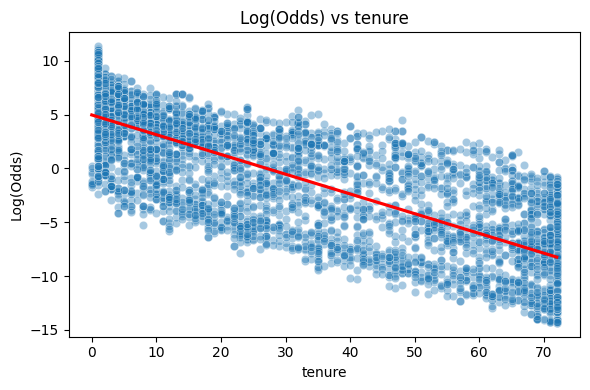

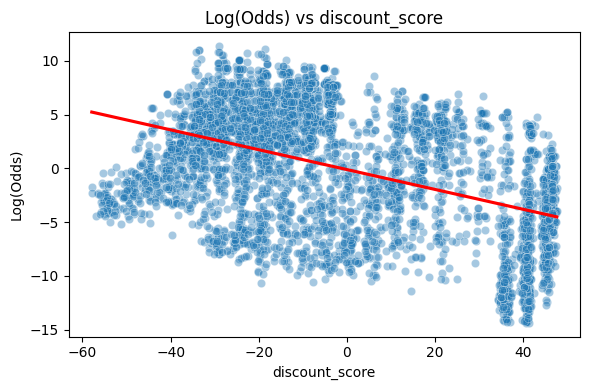

In [ ]:
#Linearity Assumption: Logit vs Continuous Features
preds = log_model.predict_proba(X_train)[:, 1]
log_odds = np.log(preds / (1 - preds))
for feature in continuous_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X_train[feature], y=log_odds, alpha=0.4)
    sns.regplot(x=X_train[feature], y=log_odds, scatter=False, color='red', ci=None)
    plt.title(f'Log(Odds) vs {feature}')
    plt.ylabel('Log(Odds)')
    plt.tight_layout()
    plt.show()

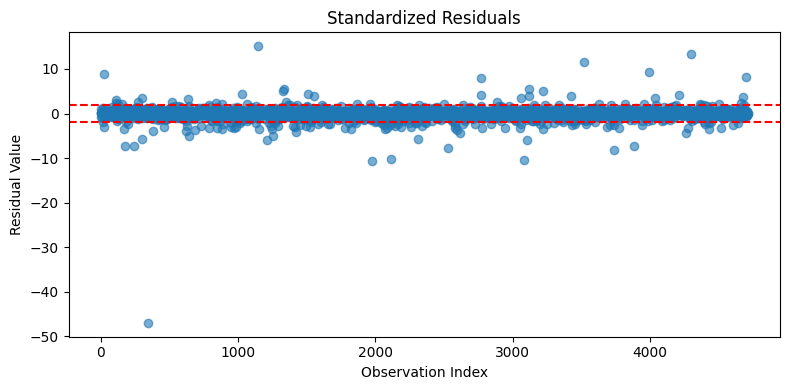

In [ ]:
#Outliers and Influence (Standardized Residuals + Cook’s Distance)
influence = logit_model.get_influence()
standardized_residuals = influence.resid_studentized
plt.figure(figsize=(8, 4))
plt.scatter(range(len(standardized_residuals)), standardized_residuals, alpha=0.6)
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='red', linestyle='--')
plt.title("Standardized Residuals")
plt.ylabel("Residual Value")
plt.xlabel("Observation Index")
plt.tight_layout()
plt.show()

Most points fall within the ±2 range, which is good — it suggests residuals are generally well-behaved.

There's no clear pattern or funnel shape → this supports the assumption of homoscedasticity (constant variance) and that the model is correctly specified.

Since the vast majority are concentrated near 0, the overall model seems robust.

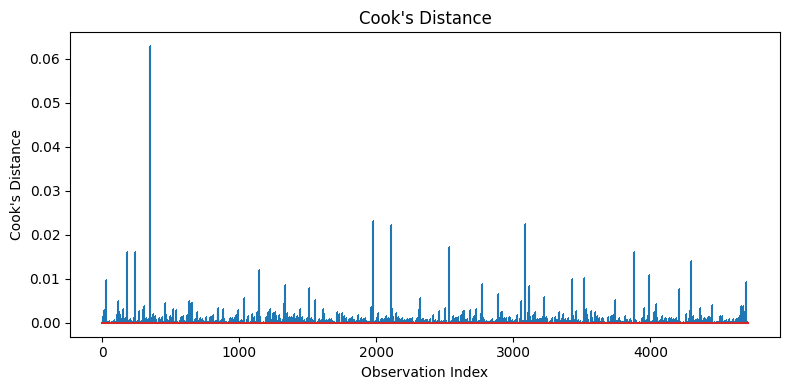

In [ ]:
cooks_d = influence.cooks_distance[0]
plt.figure(figsize=(8, 4))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.title("Cook's Distance")
plt.ylabel("Cook's Distance")
plt.xlabel("Observation Index")
plt.tight_layout()
plt.show()

In the plot most values are near zero, indicating low influence which is good.

However, a few spikes appear, suggesting potentially influential points. These are not necessarily outliers but may be high-leverage or high-residual cases.

In [ ]:
#Feature Transformation Based on Linearity Tests
X_train['MonthlyCostPerTenure_log'] = np.log(X_train['MonthlyCostPerTenure'] + 1)
X_test['MonthlyCostPerTenure_log'] = np.log(X_test['MonthlyCostPerTenure'] + 1)
X_train['tenure_sqrt'] = np.sqrt(X_train['tenure'])
X_test['tenure_sqrt'] = np.sqrt(X_test['tenure'])

In [ ]:
#Bin non-linear features
X_train['cost_group'] = pd.qcut(X_train['MonthlyCostPerTenure_log'], q=4, duplicates='drop')
X_test['cost_group'] = pd.cut(X_test['MonthlyCostPerTenure_log'], bins=np.unique(X_train['MonthlyCostPerTenure_log'].quantile([0, 0.25, 0.5, 0.75, 1]).values), include_lowest=True)

X_train['charge_group'] = pd.qcut(X_train['TotalCharges'], q=4, duplicates='drop')
X_test['charge_group'] = pd.cut(X_test['TotalCharges'], bins=np.unique(X_train['TotalCharges'].quantile([0, 0.25, 0.5, 0.75, 1]).values), include_lowest=True)

X_train['tenure_group'] = pd.qcut(X_train['tenure_sqrt'], q=4, duplicates='drop')
X_test['tenure_group'] = pd.cut(X_test['tenure_sqrt'], bins=np.unique(X_train['tenure_sqrt'].quantile([0, 0.25, 0.5, 0.75, 1]).values), include_lowest=True)

In [ ]:
# Drop non-linear original features
X_train.drop(columns=['MonthlyCostPerTenure', 'MonthlyCostPerTenure_log', 'TotalCharges', 'tenure', 'tenure_sqrt'], inplace=True, errors='ignore')
X_test.drop(columns=['MonthlyCostPerTenure', 'MonthlyCostPerTenure_log', 'TotalCharges', 'tenure', 'tenure_sqrt'], inplace=True, errors='ignore')

In [ ]:
# One-hot encode binned variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [ ]:
#Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)


Logistic Regression Evaluation
Accuracy: 0.94
Precision: 0.93
Recall: 0.95
F1 Score: 0.94
AUC: 0.93
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       544
           1       0.93      0.95      0.94       635

    accuracy                           0.94      1179
   macro avg       0.94      0.93      0.94      1179
weighted avg       0.94      0.94      0.94      1179



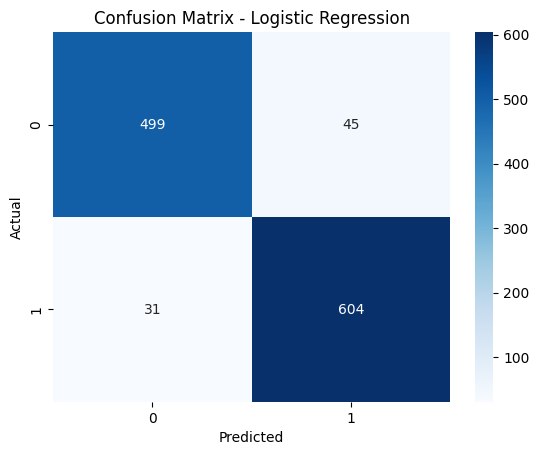

In [ ]:
log_model = LogisticRegression(max_iter=1000, solver='liblinear')
log_model.fit(X_train_scaled, y_train)
evaluate_model("Logistic Regression", log_model, X_test_scaled, y_test)

## SHAP for Logistic Regression


SHAP Summary for Logistic Regression


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


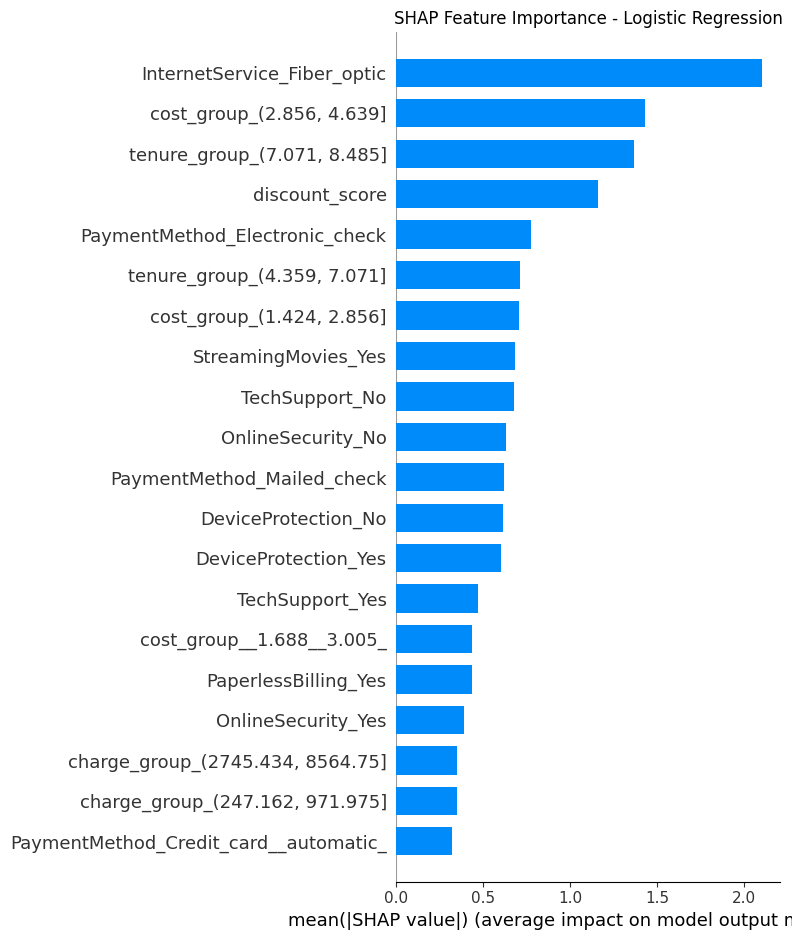

In [ ]:
print("\nSHAP Summary for Logistic Regression")
explainer_log = shap.LinearExplainer(log_model, X_train_df, feature_perturbation="interventional")
shap_values_log = explainer_log.shap_values(X_test_df)
shap.summary_plot(shap_values_log, X_test_df, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - Logistic Regression")
plt.tight_layout()
plt.show()

The SHAP feature importance plot for the Logistic Regression model reveals that InternetService_Fiber_optic is the most influential factor in predicting churn, with customers using fiber optic connections being significantly more likely to leave. This likely reflects dissatisfaction with pricing or service quality.

Other strong predictors include cost_group bins (based on MonthlyCostPerTenure) and tenure_group, showing that customers who pay more relative to their tenure or who are in the early stages of their subscription have a higher likelihood of churning. The discount_score also plays a key role, suggesting that
customers who do not receive discounts or promotions are more prone to churn.

Additionally, PaymentMethod_Electronic_check is strongly associated with higher churn rates, which may reflect lower customer satisfaction or financial instability.

Service-related variables such as TechSupport_No, OnlineSecurity_No, and the absence of streaming or backup services also contribute to the prediction, indicating that customers lacking these added-value services are more likely to discontinue the service.

In contrast, features like PaymentMethod_Credit_card and lower-cost or mid-tenure groups have comparatively less impact on the model’s predictions.

Overall, the model relies heavily on cost sensitivity, tenure length, service utility, and payment behavior to assess churn risk.

## LIME for Logistic Regression

In [ ]:
print("\nLIME Explanation for Logistic Regression")
explainer_lime = LimeTabularExplainer(X_train_df.values, feature_names=X_train_df.columns.tolist(), class_names=['No Churn', 'Churn'], discretize_continuous=True)
sample_instance = X_test_df.iloc[0]
exp = explainer_lime.explain_instance(sample_instance.values, log_model.predict_proba)
exp.show_in_notebook()


LIME Explanation for Logistic Regression


The LIME explanation for the Logistic Regression model provides a local interpretation of a single customer prediction, where the model assigned a 96% probability of churn. The key features contributing to this prediction include the customer’s tenure_group (7.071, 8.485], which indicates very short tenure and suggests that newer customers are at higher churn risk.

Additionally, belonging to higher cost_group bins—particularly the ranges (2.856, 4.639] and (4.359, 7.071]—further increases churn probability, reflecting dissatisfaction with higher perceived costs in a short usage span. The use of InternetService_Fiber_optic also adds to churn risk, which aligns with global SHAP findings that associate this service type with higher churn rates.

On the other hand, features that slightly mitigate the churn prediction include being in lower cost or tenure groups, as well as service-related attributes such as StreamingMovies_Yes and OnlineSecurity_Yes, which indicate that customers with value-added services are more likely to stay.

Interestingly, the discount_score in this case is relatively low (0.79), contributing modestly to churn, possibly due to insufficient promotions or perceived value.

Overall, the LIME explanation highlights how recent customers with high costs and limited service benefits are at the greatest risk of leaving.

## PFI for Logistic Regression

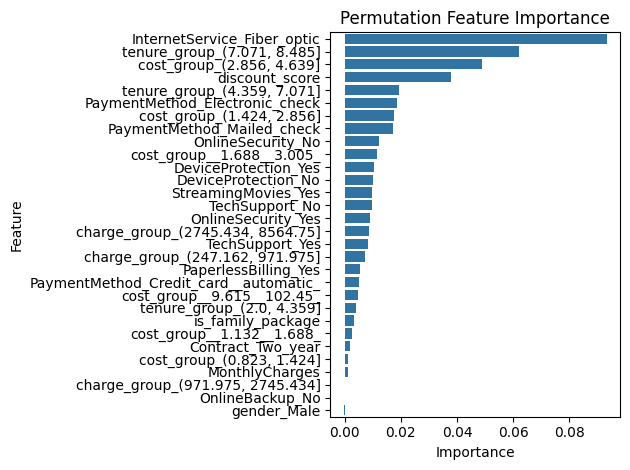

In [ ]:
from sklearn.inspection import permutation_importance

perm_result = permutation_importance(log_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

perm_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": perm_result.importances_mean
}).sort_values(by="Importance", ascending=False)

sns.barplot(data=perm_df, x="Importance", y="Feature")
plt.title("Permutation Feature Importance")
plt.tight_layout()
plt.show()


The permutation importance plot for the logistic regression model reveals that InternetService_Fiber_optic is the most influential feature, with the largest negative impact on model performance when permuted. This suggests that customers using fiber optic internet are significantly more likely to churn.

Other highly important features include tenure_group_(7.071, 8.485], cost_group_(2.856, 4.639], and discount_score. These indicate that:

Customers with medium tenure are more likely to churn than those with very low or very high tenure,

Those paying higher monthly costs per tenure unit are also at elevated churn risk,

And those receiving fewer discounts (or showing higher price sensitivity) contribute more significantly to churn.

Features such as PaymentMethod_Electronic_check, OnlineSecurity_No, and TechSupport_No also appear influential, highlighting that customers lacking support/security services and using less stable payment methods are at greater risk of leaving.

In contrast, features like gender_Male, OnlineBackup_No, and certain lower-tier charge groups show minimal importance, suggesting they have little predictive power in this context.

Overall, the model’s decision-making is strongly influenced by a combination of service quality, billing behavior, and tenure-related factors, all of which align with typical churn behavior in subscription-based industries.



## Coefficients + Statistical Significance (p-values)

In [ ]:
X_sm = add_constant(X_train_df)
logit_model = sm.Logit(y_train, X_sm).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.141089
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      0   No. Observations:                 4712
Model:                          Logit   Df Residuals:                     4681
Method:                           MLE   Df Model:                           30
Date:                Thu, 01 May 2025   Pseudo R-squ.:                  0.7956
Time:                        00:54:54   Log-Likelihood:                -664.81
converged:                       True   LL-Null:                       -3252.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.0295     

The logistic regression model demonstrates a strong overall fit, with a pseudo R-squared of 0.7956, indicating that approximately 79.6% of the variance in churn is explained by the model. The model has converged successfully, and the likelihood ratio test is significant (p < 0.001), validating the overall model effectiveness.

Among the most statistically significant positive predictors of churn are:

InternetService_Fiber_optic (β = 2.1064, p < 0.001): Customers using fiber optic internet have significantly higher odds of churning.

cost_group_(2.856, 4.639] (β = 1.6066, p < 0.001): Customers in the higher cost-per-tenure group are much more likely to churn.

discount_score (β = 22.7306, p < 0.001) and MonthlyCharges (β = 21.7574, p < 0.001): Higher spending and discount sensitivity are strongly associated with churn.

PaymentMethod_Electronic_check and TechSupport_No also contribute significantly to increased churn likelihood.

On the other hand, features like:

tenure_group_(7.071, 8.485] (β = -1.6235, p < 0.001) and tenure_group_(4.359, 7.071] (β = -1.0132, p < 0.001) are negatively associated with churn, meaning customers with longer tenure are much less likely to churn.

is_family_package (β = -0.3045, p < 0.001) shows that customers in family plans are less prone to leave.

Some predictors, such as OnlineBackup_No, gender_Male, and several lower charge groups, do not show significant impact (p > 0.05), implying their contribution to churn is relatively minor or statistically inconclusive.

Overall, the model emphasizes the importance of billing behavior, tenure segmentation, service type (fiber), and payment method in influencing churn, offering clear guidance for targeted retention strategies.